In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Libraries

In [ ]:
# Import packages
%config Completer.use_jedi = False

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from keras.utils.vis_utils import plot_model


from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import cv2
import albumentations as A
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.utils import to_categorical
from random import seed
from random import randint
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from keras.models import model_from_json
from sklearn.metrics import cohen_kappa_score, roc_auc_score, roc_curve,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load data

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/EMOCNN/fer2013.csv')
train_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Organize Labels¶


In [ ]:
# Convert the string of pixels to an array
train_df['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in train_df['pixels']]

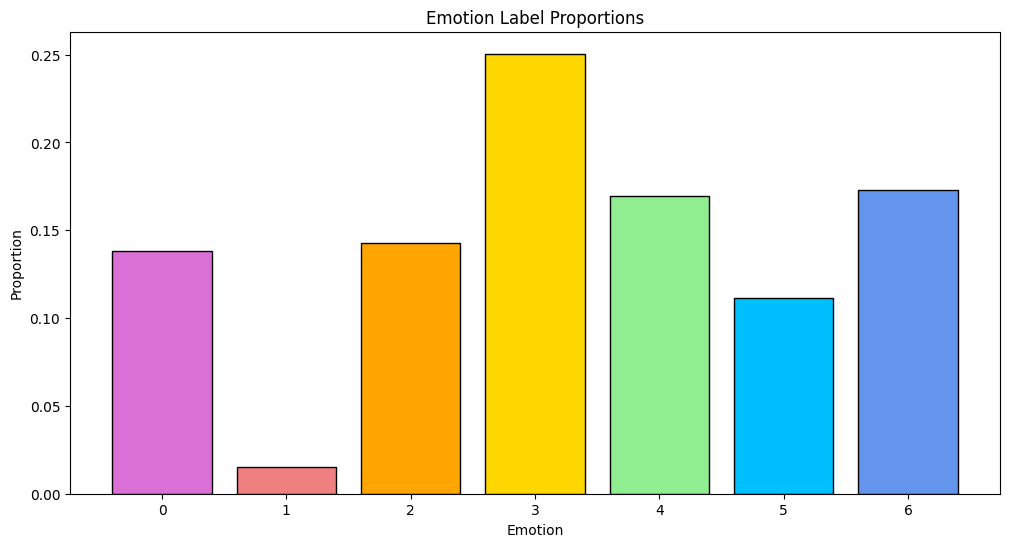

In [ ]:
# Assign the emotions to the corresponding number and apply them to the DataFrame
emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

#train_df['emotion'] = train_df['emotion'].apply(lambda x: emotion_cat[x])

# Create variables for pixels and labels
pixels = np.concatenate(train_df['pixels'])
labels = train_df.emotion.values

emotion_prop = (train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index(ascending=True)

# Create a bar chart for the labels
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotion_prop.index, height=emotion_prop['emotion'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()


## Converting strings to array¶


In [ ]:
# Print the shape of both arrays
print(pixels.shape)
print(labels.shape)

(35887, 48, 48, 1)
(35887,)


In [ ]:
# Split the data into a training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.15, stratify=labels, random_state=1
)


# View the shapes of the data sets
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (30503, 48, 48, 1)
y_train Shape: (30503,)

X_valid Shape: (5384, 48, 48, 1)
y_valid Shape: (5384,)


In [ ]:
# Standardize the pixel values between 0 and 1
Xs_train = X_train / 255
Xs_valid = X_valid / 255

## Using random data augmentation

In [ ]:
# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    fill_mode = 'nearest'
)

train_loader = train_datagen.flow(Xs_train, y_train, batch_size=64)

## Create model

In [ ]:
def Dense_Model():
  input_shape_densenet = (48, 48, 3)
  densenet_model = keras.applications.DenseNet201(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=input_shape_densenet
  )
  
  densenet_model.trainable = True


  input = keras.Input(shape=(48, 48, 3))
  layer = densenet_model(inputs=input)
  layer = keras.layers.Flatten()(layer)
  layer = keras.layers.Dense(units=512, activation='relu')(layer)
  layer = keras.layers.Dropout(0.4)(layer)
  layer = keras.layers.Dense(units=256, activation='relu')(layer)
  layer = keras.layers.Dropout(0.4)(layer)
  layer = keras.layers.Dense(units=128, activation='relu')(layer)
  layer = keras.layers.Dropout(0.3)(layer)
  output = keras.layers.Dense(units=7, activation='softmax')(layer)

  model = keras.models.Model(inputs=input, outputs=output)
  return model

In [ ]:
model = Dense_Model()

74836368/74836368 [==============================] - 3s 0us/step


In [ ]:
np.random.seed(51)
tf.random.set_seed(51)

#cnn = DenseNet
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

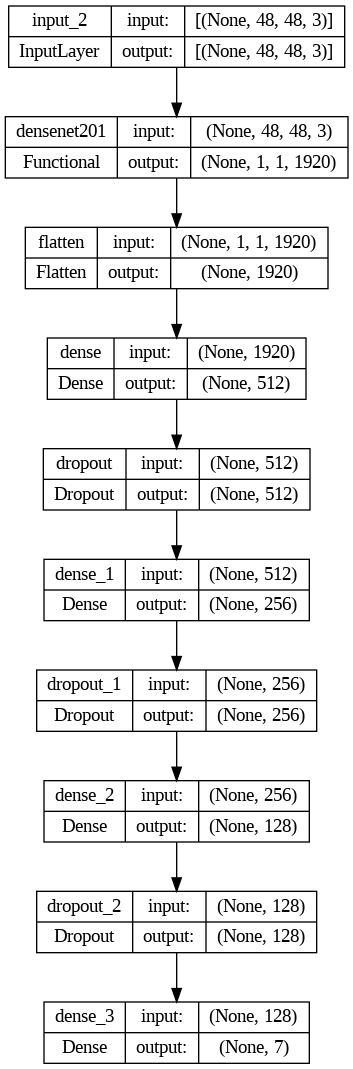

In [ ]:

plot_model(model, to_file='/content/drive/MyDrive/EMOCNN/DenseNet_model.png', show_shapes=True, show_layer_names=True)


## Train the model

In [ ]:
# Set up the optimizer
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
%%time
# Training Run #1
h1 = model.fit(train_loader, 
             batch_size=64, 
             epochs=100, 
             validation_data=(Xs_valid, y_valid), verbose=1)

Epoch 1/100


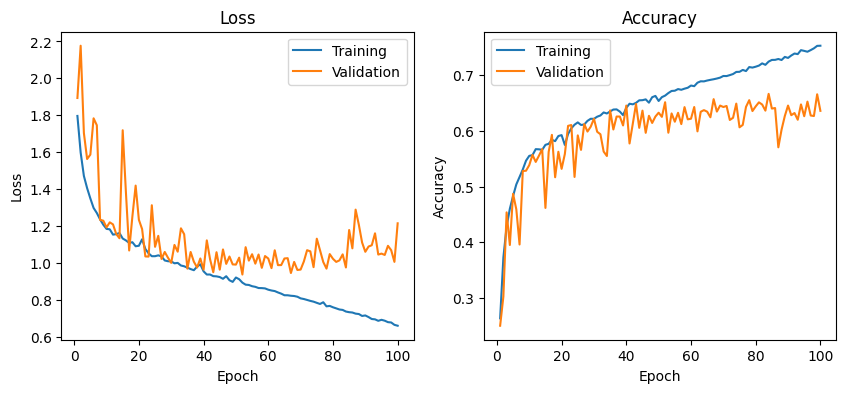

In [ ]:
# Save history and view plots of loss and accuracy
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# save model structure in jason file
model_json = model.to_json()
with open("/content/drive/MyDrive/EMOCNN/DenseNet201.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
model.save_weights('/content/drive/MyDrive/EMOCNN/DenseNet201.h5')

## Training Run 2¶


In [ ]:
# Update the learning rate
tf.keras.backend.set_value(model.optimizer.learning_rate, 0.0001)

In [ ]:
%%time 

# Training Run #2
h2 = model.fit(train_loader, 
             batch_size=64, 
             epochs=40, 
             validation_data=(Xs_valid, y_valid), verbose=1)

Epoch 1/40
477/477 [==============================] - 63s 131ms/step - loss: 0.6035 - accuracy: 0.7748 - val_loss: 1.0000 - val_accuracy: 0.6727
Epoch 2/40
477/477 [==============================] - 61s 128ms/step - loss: 0.5722 - accuracy: 0.7857 - val_loss: 1.0189 - val_accuracy: 0.6750
Epoch 3/40
477/477 [==============================] - 61s 128ms/step - loss: 0.5670 - accuracy: 0.7879 - val_loss: 1.0339 - val_accuracy: 0.6772
Epoch 4/40
477/477 [==============================] - 62s 129ms/step - loss: 0.5559 - accuracy: 0.7924 - val_loss: 1.0544 - val_accuracy: 0.6753
Epoch 5/40
477/477 [==============================] - 62s 130ms/step - loss: 0.5491 - accuracy: 0.7939 - val_loss: 1.0593 - val_accuracy: 0.6681
Epoch 6/40
477/477 [==============================] - 62s 131ms/step - loss: 0.5397 - accuracy: 0.7966 - val_loss: 1.0767 - val_accuracy: 0.6679
Epoch 7/40
477/477 [==============================] - 61s 127ms/step - loss: 0.5373 - accuracy: 0.7994 - val_loss: 1.0746 - val_ac

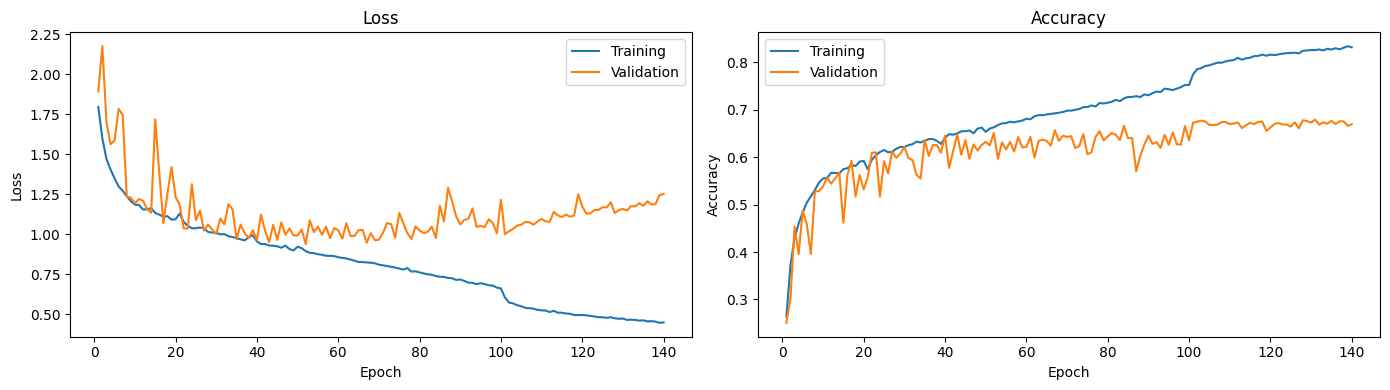

In [ ]:
# Save history and view plots of loss and accuracy
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Training Run 3¶


In [ ]:
# Update the learning rate
tf.keras.backend.set_value(model.optimizer.learning_rate, 0.00001)

In [ ]:
%%time 

# Training Run #3
h3 = model.fit(train_loader, 
             batch_size=64, 
             epochs=20, 
             validation_data=(Xs_valid, y_valid), verbose=1)

Epoch 1/20
477/477 [==============================] - 63s 133ms/step - loss: 0.4392 - accuracy: 0.8375 - val_loss: 1.2525 - val_accuracy: 0.6694
Epoch 2/20
477/477 [==============================] - 63s 131ms/step - loss: 0.4458 - accuracy: 0.8356 - val_loss: 1.2242 - val_accuracy: 0.6733
Epoch 3/20
477/477 [==============================] - 64s 134ms/step - loss: 0.4380 - accuracy: 0.8348 - val_loss: 1.2384 - val_accuracy: 0.6729
Epoch 4/20
477/477 [==============================] - 61s 129ms/step - loss: 0.4418 - accuracy: 0.8365 - val_loss: 1.2416 - val_accuracy: 0.6718
Epoch 5/20
477/477 [==============================] - 62s 130ms/step - loss: 0.4374 - accuracy: 0.8363 - val_loss: 1.2324 - val_accuracy: 0.6714
Epoch 6/20
477/477 [==============================] - 61s 128ms/step - loss: 0.4341 - accuracy: 0.8390 - val_loss: 1.2346 - val_accuracy: 0.6699
Epoch 7/20
477/477 [==============================] - 62s 129ms/step - loss: 0.4363 - accuracy: 0.8387 - val_loss: 1.2301 - val_ac

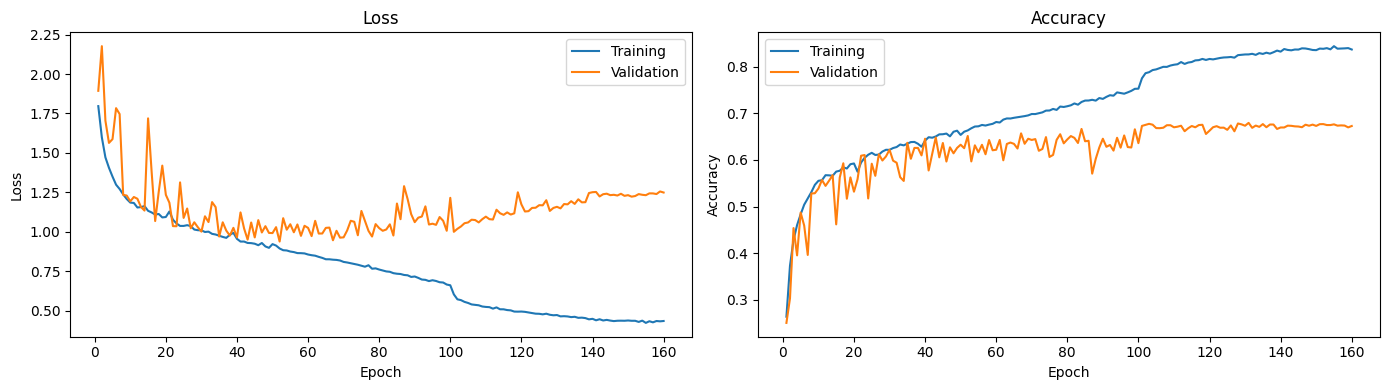

In [ ]:
# Save history and view plots of loss and accuracy
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#save 2nd model after 20 last epochs

In [ ]:
# save model structure in jason file
model_json = xception.to_json()
with open("/content/drive/MyDrive/EMOCNN/emotion_model20.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
xception.save_weights('/content/drive/MyDrive/EMOCNN/emotion_model20.h5')

In [ ]:
# Save the model
xception.save('/content/drive/MyDrive/EMOCNN/fer_XceptionV320.h5')
pickle.dump(history, open(f'/content/drive/MyDrive/EMOCNN/fer_XceptionV320.pkl', 'wb'))